# Extract Overshoot from Profiles

In [121]:
%matplotlib inline

import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal
import matplotlib.ticker as mticker
import math
import csv

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 12.
plt.rcParams['lines.markeredgewidth'] = 0.7

In [122]:
main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'
fname = os.path.join(main_path,'[!m]*')
fileL = glob.glob(fname) #list of files
# [fileL.remove(file) for file in fileL if '_' in file]; 
[fileL.remove(file) for file in fileL if 'Plume' in file];
path_list = sorted (fileL, key = lambda x: (len (x), x))
fileL = [file.replace(main_path,'') for file in fileL]
ra_path = sorted (fileL, key = lambda x: (len (x), x))

# path_list.pop(8)
# ra_path.remove('3e9')

lenRa = len(ra_path)

In [123]:
data = [[] for i in range(lenRa)] #empty nested list

for i in range(lenRa):
    if ra_path[i]=='3e8':
        fname = os.path.join(path_list[i]+'\\512\\','[!m]*.txt')
    else:
        fname = os.path.join(path_list[i]+'\\256\\','[!m]*.txt')
#     fname = os.path.join(path_list[i]+'\\256\\','[!m]*.txt')
    fileL = glob.glob(fname) #list of files
    temp = []
    for file in fileL:
        a = fileL.index(file)
        b = pd.read_csv(file,header=None)
        b.rename(columns={0:a}, inplace=True)
        temp.append(b)
    if ra_path[i]=='3e8':
        toDF = np.reshape(temp,(3,513),order='A')
    else:
        toDF = np.reshape(temp,(3,257),order='A') 
#     toDF = np.reshape(temp,(3,257),order='A') 
    DF = pd.DataFrame(toDF.T)
    DF.rename(columns={0:'Radius',2:'Temperature',1:'Velocity'},inplace=True)
    DF['Ra']=float(ra_path[i])
    data[i] = DF

,Ra,Depth,Overshoot,Interior,Difference
0,1.000000e+04,0.684615,0.511778,0.500006,0.011773
1,1.000000e+05,0.869231,0.518730,0.499990,0.018740
2,1.000000e+06,0.937999,0.521842,0.499950,0.021892
3,3.000000e+06,0.952401,0.541848,0.500455,0.041393
4,1.000000e+07,0.966401,0.541777,0.499832,0.041945
5,3.000000e+07,0.976001,0.541430,0.502377,0.039053
6,1.000000e+08,0.980002,0.529341,0.500609,0.028733
7,3.000000e+08,0.988236,0.533824,0.501151,0.032673
8,6.000000e+08,0.987999,0.524280,0.500033,0.024247
9,1.000000e+09,0.989999,0.520940,0.498534,0.022406


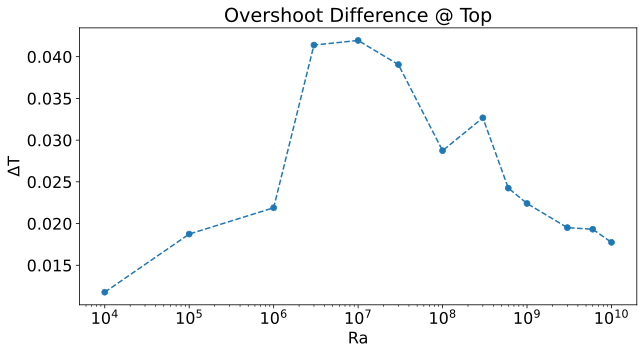

In [124]:
to = []
ti = []
ra = []
zz = []
for i in range(lenRa-2):
    max_len = len(data[i]['Temperature'])
    mid_len = int(len(data[i]['Temperature'])/2)
    to.append(data[i]['Temperature'].truncate(before=mid_len, after=max_len).max())
    ti.append(data[i]['Temperature'][mid_len])
    ra.append(data[i]['Ra'][0])
    idx = np.where(data[i]['Temperature']==data[i]['Temperature'].truncate(before=mid_len, after=max_len).max())[0][0]
    zz.append(data[i]['Radius'][idx])
to = np.array(to)
ti = np.array(ti)
ra = np.array(ra)
zz = np.array(zz)

result = pd.DataFrame({'Ra': ra, 'Depth' : zz,'Overshoot': to, 'Interior': ti, 'Difference':to-ti})
result = result.sort_values(by=['Ra'])
result = result.reset_index(drop=True)

plt.plot(result['Ra'],result['Difference'],'.',linestyle='--')
plt.xscale('log');
# plt.axvline(3e6);
plt.title('Overshoot Difference @ Top')
plt.xlabel('Ra')
plt.ylabel('ΔT');
image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'overshoot_top.png',pad_inches=0.1,bbox_inches='tight');

save_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Data\\'
result.to_csv(save_path+'overshoot_data.csv', index=False)
result

,Ra,Overshoot,Interior,Difference
0,1.000000e+04,0.488232,0.500006,-0.011774
1,1.000000e+05,0.481250,0.499990,-0.018740
2,1.000000e+06,0.478128,0.499950,-0.021822
3,3.000000e+06,0.459146,0.500455,-0.041309
4,1.000000e+07,0.459727,0.499832,-0.040105
5,3.000000e+07,0.459364,0.502377,-0.043013
6,1.000000e+08,0.475899,0.500609,-0.024710
7,3.000000e+08,0.467809,0.501151,-0.033342
8,6.000000e+08,0.476948,0.500033,-0.023085
9,1.000000e+09,0.476768,0.498534,-0.021766


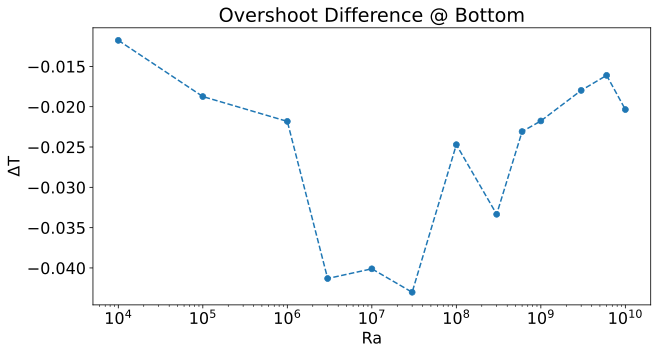

In [125]:
to = []
ti = []
ra = []
for i in range(lenRa-2):
    max_len = len(data[i]['Temperature'])
    mid_len = int(len(data[i]['Temperature'])/2)
    to.append(data[i]['Temperature'].truncate(before=0, after=mid_len).min())
    ti.append(data[i]['Temperature'][mid_len])
    ra.append(data[i]['Ra'][0])
to = np.array(to)
ti = np.array(ti)
ra = np.array(ra)

result2 = pd.DataFrame({'Ra': ra, 'Overshoot': to, 'Interior': ti, 'Difference':to-ti})
result2 = result2.sort_values(by=['Ra'])
result2 = result2.reset_index(drop=True)

plt.plot(result2['Ra'],result2['Difference'],'.',linestyle='--')
plt.xscale('log');
# plt.axvline(3e6);
plt.title('Overshoot Difference @ Bottom')
plt.xlabel('Ra')
plt.ylabel('ΔT');
image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'overshoot_bot.png',pad_inches=0.1,bbox_inches='tight');

result2

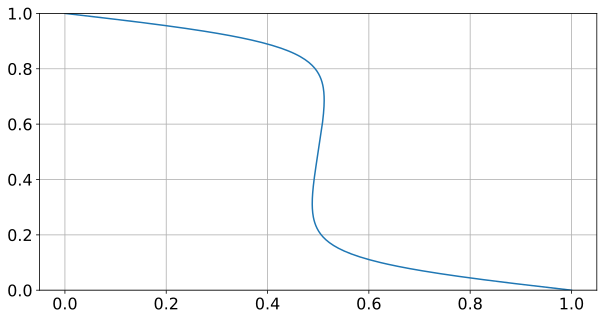

In [126]:
xx = data[0]['Temperature']
yy = data[0]['Radius']
plt.plot(xx,yy)
plt.ylim(0,1)
# plt.xlim(0.4,0.6)
plt.grid();

In [127]:
# from matplotlib import collections as matcoll
# lines = []; select = [1,4,6,12];
# for i in select:
#     pair=[(result['Ra'][i],0.01), (result['Ra'][i], result['Difference'][i])]
#     lines.append(pair)

# linecoll = matcoll.LineCollection(lines)
# fig, ax = plt.subplots()
# ax.add_collection(linecoll)

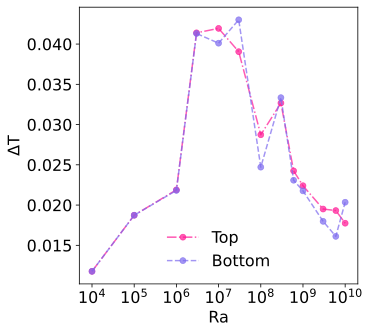

In [128]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(result['Ra'],abs(result['Difference']),'.',linestyle='-.',alpha=0.7,label='Top', color='deeppink')
plt.plot(result2['Ra'],abs(result2['Difference']),'.',linestyle='--',alpha=0.7,label='Bottom', color='mediumslateblue')
plt.xscale('log');
# plt.title('Overshoot Difference Both')
plt.xlabel('Ra')
plt.ylabel('ΔT');
plt.xticks(np.logspace(4,10,num=7));
plt.legend(frameon=False,loc='lower center');
image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'overshoot_both.png',pad_inches=0.1,bbox_inches='tight');

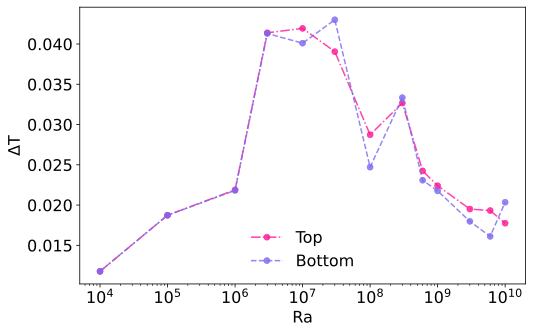

In [129]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(result['Ra'],abs(result['Difference']),'.',linestyle='-.',alpha=0.8,label='Top', color='deeppink')
plt.plot(result2['Ra'],abs(result2['Difference']),'.',linestyle='--',alpha=0.8,label='Bottom', color='mediumslateblue')
plt.xscale('log');
# plt.title('Overshoot Difference Both')
plt.xlabel('Ra')
plt.ylabel('ΔT');
plt.xticks(np.logspace(4,10,num=7));
plt.legend(frameon=False,prop={'size': 16},loc='lower center');
image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'overshoot_both_long.png',pad_inches=0.1,bbox_inches='tight');

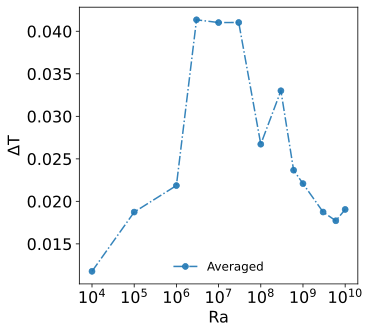

In [130]:
plt.rcParams['figure.figsize'] = [5, 5]
average_top_bot = (abs(result['Difference'])+abs(result2['Difference']))/2
plt.plot(result['Ra'],average_top_bot,'.',linestyle='-.',alpha=0.9,label='Averaged')
plt.xscale('log');
# plt.title('Overshoot Difference Both')
plt.xlabel('Ra')
plt.ylabel('ΔT');
plt.xticks(np.logspace(4,10,num=7));
plt.legend(frameon=False,prop={'size': 12},loc='lower center');

In [131]:
save_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Data\\'
Data=pd.read_csv(save_path+'data_short.csv')
Data.drop(Data.tail(2).index,inplace = True)
Data

,Ra,NuT,NuB,VRMS,Surface
0,1.000000e+04,4.656117,4.656052,34.289954,31.914000
1,1.000000e+05,11.254625,11.254650,168.172663,165.990000
2,1.000000e+06,23.502768,23.502513,703.962729,710.800000
3,3.000000e+06,31.091243,31.102263,1724.080856,1861.224138
4,1.000000e+07,45.752733,45.729992,3694.501261,3969.992941
5,3.000000e+07,64.545929,64.185931,7409.134055,7885.750000
6,1.000000e+08,82.274544,81.669792,8657.461368,8286.840800
7,3.000000e+08,128.210292,128.165251,28979.412563,30769.912037
8,6.000000e+08,163.818558,164.114764,47506.283676,50508.465035
9,1.000000e+09,173.733978,174.123207,43355.162240,40996.437276


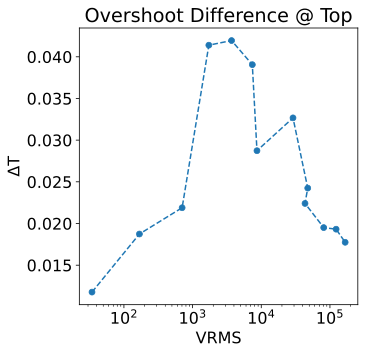

In [132]:
plt.plot(Data['VRMS'],result['Difference'],'.',linestyle='--')
plt.xscale('log');
# plt.axvline(3e6);
plt.title('Overshoot Difference @ Top')
plt.xlabel('VRMS')
plt.ylabel('ΔT');

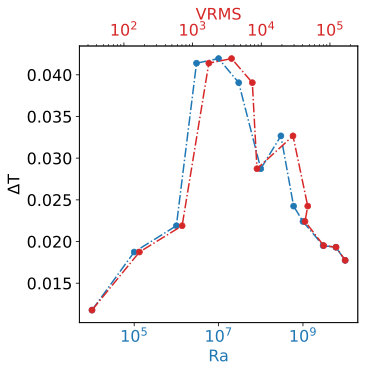

In [133]:
fig, ax1 = plt.subplots(figsize=(5,5))
plt.xscale('log'); 
plt.xlabel('Ra')
plt.ylabel('ΔT')
# plt.xticks(np.logspace(4,10,num=7));
color = 'tab:blue'
ax1.set_xlabel('Ra', color=color);
ax1.tick_params(axis='x', labelcolor=color);
ax2 = ax1.twiny()  
ax1.plot(result['Ra'],result['Difference'],'.',linestyle='-.')
plt.xscale('log'); 
color = 'tab:red'
ax2.plot(Data['VRMS'],result['Difference'],'.',linestyle='-.',color=color)
plt.xscale('log');
# plt.xticks(np.logspace(4,10,num=7));
ax2.set_xlabel('VRMS', color=color);
ax2.tick_params(axis='x', labelcolor=color);

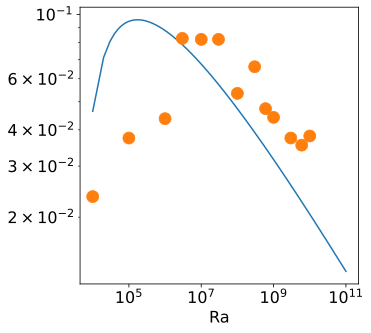

In [134]:
# plt.plot(result['Ra'],abs(result['Difference']),'.',linestyle='-.',alpha=0.9,label='Top')
# plt.plot(result2['Ra'],abs(result2['Difference']),'.',linestyle='--',alpha=0.9,label='Bottom')
xx = np.arange(1e4,1e11,1e4)
hola = -10.39*xx**(-1/3) + 4.01*xx**(-0.22)
sigma = result['Overshoot'] + 1 - result2['Overshoot'] - 1
plt.plot(xx,hola)
plt.plot(result['Ra'],sigma,'o')
plt.xscale('log');
plt.yscale('log');
# plt.title('Overshoot Difference Both')
plt.xlabel('Ra');
# plt.ylabel('ΔT');
# plt.legend(frameon=False,prop={'size': 12},loc='lower center');